# Setting boundaries on model parameters

In previous notebooks we've looked at simulation methods and performed some basic fitting.

In this notebook, we'll try to set some _boundaries_ on the parameter values we expect.
This will make our life easier in three ways:

1. By staying within a sensible region of parameter space, we can avoid numerical issues.
2. By reducing the size of the search space, we can speed up optimisations and make them more robust.
3. By sampling from within known boundaries we can derive random parameter sets to use as starting points for our search.

## Dealing with simulation issues in a ForwardModel

First, we'll show what can happen when you don't define boundaries.
We'll begin by defining a forward model that uses the `myokit.Simulation` class.

In [2]:
import matplotlib.pyplot as plt
import myokit
import myokit.lib.hh
import numpy as np
import pints
import scipy.optimize

class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
        return log['ikr.IKr']    

In [3]:
# Load a protocol and create a foward model instance
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Evaluate the model
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)

So far so good! Now let's try some random parameters

In [4]:
np.random.seed(5)
parameters = np.random.lognormal(0, 2, 9)
values = model.simulate(parameters, times)

SimulationError: A numerical error occurred during simulation at t = 0.
Last reached state: 
  ikr.act =  3.08949315565909869e-04
  ikr.rec =  6.00811199442260024e-01
Inputs for binding:
  time        = 0.0
  pace        = -80.0
  realtime    = 0.0
  evaluations = 32.0
Function CVode() failed with flag -3 CV_ERR_FAILURE: Error test failures occurred too many times during one internal time step or minimum step size was reached.

That doesn't look too good!

The `SimulationError` above tells us the ODE solver (CVODE), has either had too many "test failures", or its "minimum step size was reached".
In other words, at some point during the simulation the solver was unable to determine a step size that would lead to a good prediction for the next step.

So what can we do about it?
A first thought might be to catch the errors, and return some other output, i.e. a list of `NaN` objects:

In [5]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        try:
            log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
            return log['ikr.IKr']    
        except myokit.SimulationError:
            print('Error evaluating with parameters: ' + str(parameters))
            return np.nan * times

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)

Error evaluating with parameters: [  2.41682567   0.51595264 129.22335923   0.60399808   1.24510478
  23.68784942   0.16227468   0.30627456   1.45529183]

Values:
[nan nan nan ... nan nan nan]


That's _sort of_ better...
Now if we define some error involving this time series, it will evaluate to `nan` ("not a number").
As long as the optimisation routine can deal with that, it means we're OK?

Since this is a simple step protocol, we could also try using an analytical simulation:

In [6]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create an analytical simulation
        self.sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        self.sim.set_parameters(parameters)
        log = self.sim.run(times[-1] + 0.1, log_times=times)
        return log['ikr.IKr']    

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)


Values:
[1.35065787e-03 1.67013286e-40 1.67013286e-40 ... 1.67013286e-40
 1.67013286e-40 1.67013286e-40]


<string>:9: RuntimeWarning: overflow encountered in exp
<string>:14: RuntimeWarning: divide by zero encountered in true_divide
<string>:14: RuntimeWarning: invalid value encountered in true_divide


This seems to evaluate - although with a lot of warnings. And the results don't look very sensible either.

So we've managed to move from simulations that cause exceptions to simulations that return unusual numbers, but we're still stuck with some major downsides:

- Catching errors as shown in the first example could hide bugs in our implementation.
- Not all optimisation routines will be able to deal with `nan` or `inf`.
- Even an optimiser that _can_ deal with these values could get stuck or waste a lot of time by exploring a region of parameter space where lots of issues occur.
- When we run a simulation and get nonsense results, we don't really learn very much - except that these parameters should probably be avoided. It'd be better if we could avoid running these simulations altogether.

Let's try to be a bit more clever and define _boundaries_ on the parameter space.

## How to determine parameter bounds

To derive boundaries on our parameters, we start by taking another look at the model:

$$ I = g_\text{max} \cdot a \cdot r \cdot (V - E) $$

\begin{align}
\dot{a} = (1 - a)k_1 - a k_2
    &&& k_1 = p_1 \exp(p_2 V) \\
    &&& k_2 = p_3 \exp(-p_4 V) \\
\dot{r} = (1 - r)k_4 - r k_3
    &&& k_3 = p_5 \exp(p_6 V) \\
    &&& k_4 = p_7 \exp(-p_8 V)
\end{align}

$$p_9 = g_\text{max} $$

and its alternative form:

\begin{align}
\dot{a} = \frac{a_\infty - a}{\tau_a}
    && \tau_a = \frac{1}{k_1 + k_2}
    && a_\infty = \frac{k_1}{k_1 + k_2} \\
\dot{r} = \frac{r_\infty - r}{\tau_r}
    && \tau_r = \frac{1}{k_3 + k_4}
    && r_\infty = \frac{k_4}{k_3 + k_4}
\end{align}


### Limits on the "a" parameters ($p_{1,3,5,7}$)


The "a" parameters $p_1, p_3, p_5, p_7$ will have roughly the same order of magnitude as the rate coefficients $k_i$.
In fact, $k_1(0 \text{mV}) = p_1$, and $k_2(0 \text{mV}) = p_3$ so that $\tau_a(0 \text{mV}) = 1 / (p_1 + p_3)$.
If we assume that $p_1$ and $p_3$ are of a similar magnitude, we get $p_1 \approx p_3 \approx 1 / (2 \tau_a)$.

So one method of setting boundaries for these parameters is to search the literature for estimates of $k_i$ or $\tau_a$ and $\tau_r$ and base our boundaries on them.

For example, we could look in Figure 11 of [Sanguinetti et al., 1990](https://doi.org/10.1085/jgp.96.1.195), which reports a value of $\tau_a(0) \approx 50\text{ms}$ for $I_\text{Kr}$ measured in Guinea pig myocytes at $35^\circ\text{C}$.
Or Figure 2C in [Sanguinetti et al., 1995](https://doi.org/10.1016/0092-8674(95)90340-2), which records $\tau_a(0) \approx 800\text{ms}$ for hERG currents recorded in an expression system at $21^\circ\text{C}$-$23^\circ\text{C}$.
Figure 11 in [Vandenberg et al., 2012](https://doi.org/10.1152/physrev.00036.2011) shows a similar order of magnitude, with $\tau_a(0) = 127\text{ms}$.

So we might expect $\tau_a$ to be around $50\text{ms}$ to $800\text{ms}$, which would place $p_1$ and $p_3$ somewhere in the range of $1 / (2\cdot50) = 10^{-2}$ to $1 / (2\cdot800) = 6.25\cdot10^{-4}$.
To play it safe, we can define some much wider bounds around this margin, and set e.g. $p_{1,3} \in [10^{-7}, 10^1]$.

We could also try and estimate some parameters directly from the data, and use this to inform a more refined search later.
For example, Figure 13a of [Vandenberg et al., 2012](https://doi.org/10.1152/physrev.00036.2011) shows time constants for inactivation/recovery ($r$), which we've digitised below.

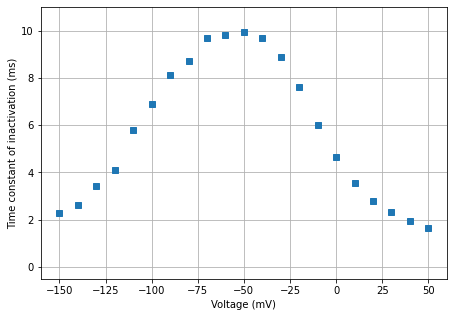

In [7]:
voltage = np.arange(-150, 60, 10)
tau_r = np.array([
    2.2966, 2.6435, 3.4241, 4.1006, 5.7832, 6.876, 8.1422, 
    8.6973, 9.686, 9.8075, 9.9289, 9.6687, 8.9055, 7.6219,
    6.026, 4.673, 3.5455, 2.7954, 2.314, 1.9366, 1.6548])

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)
plt.grid(True)
plt.show()

When discussing this figure, Vandenberg et al. make some great observations.
First, they define $k_\text{observed} = k_3 + k_4 = 1 / \tau_r$, and plot this on a semi-log scale.

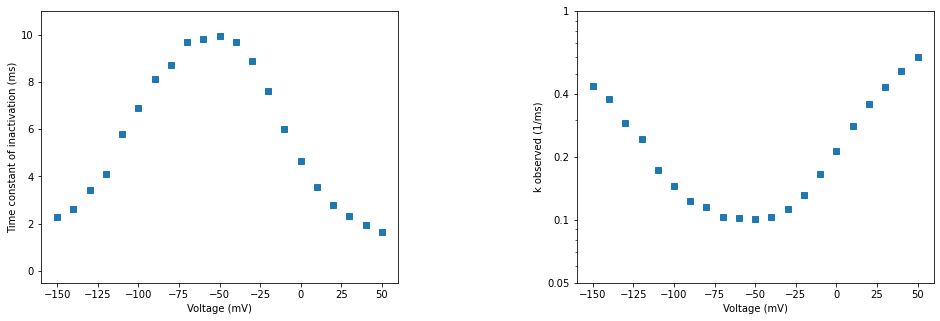

In [8]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(5e-2, 1)
ax.set_yticks([5e-2, 1e-1, 2e-1, 4e-1, 1])
ax.set_yticklabels([5e-2, 1e-1, 2e-1, 4e-1, 1])

plt.subplots_adjust(wspace=0.5)
plt.show()

Recalling that $k_\text{observered} = k_3 + k_4 = p_5 e^{+p_6 V} + p_7 e^{-p_8 V}$, the next observation is that the points on the far right (where $V$ is very positive) are dominated by $k_3$ (the rate of inactivation), while points on the far left (where $V$ is very negative) are dominated by $k_4$ (the rate of recovery).
So we can fit lines to these points, and use them to estimate $p_{5,6,7,8}$:

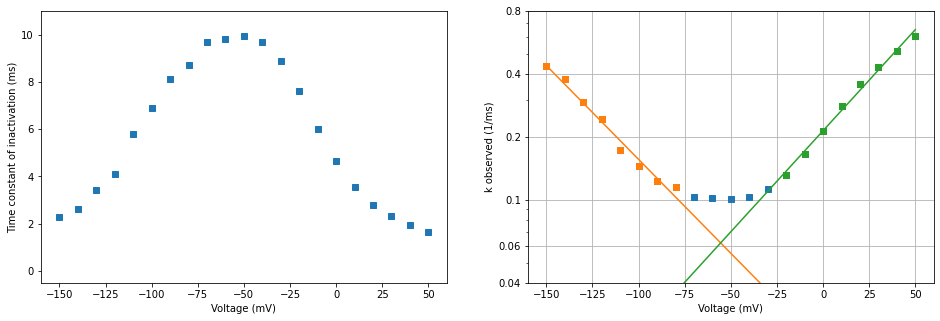

In [9]:
# Log of k observed
logk = np.log(1 / tau_r)

# Left: rate of recovery k_4 = p_7 e^(-p_8 V)
n4 = 8
minus_p8, log_p7 = np.polyfit(voltage[:n4], logk[:n4], 1)
p7 = np.exp(log_p7)
p8 = -minus_p8
k4 = p7 * np.exp(-p8 * voltage)

# Right: rate of inactivation k_3 = p_5 e^(p_6 V)
n3 = -8
p6, log_p5 = np.polyfit(voltage[n3:], logk[n3:], 1)
p5 = np.exp(log_p5)
k3 = p5 * np.exp(p6 * voltage)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.plot(voltage[:n4], 1 / tau_r[:n4], 's', color='tab:orange')
plt.plot(voltage, k4, color='tab:orange')
plt.plot(voltage[n3:], 1 / tau_r[n3:], 's', color='tab:green')
plt.plot(voltage, k3, color='tab:green')
plt.xlim(-160, 60)
plt.ylim(4e-2, 0.6)
ax.set_yticks([0.04, 0.06, 0.1, 0.2, 0.4, 0.8])
ax.set_yticklabels([4e-2, 0.06, 0.1, 0.2, 0.4, 0.8])
plt.grid(True)

plt.show()

In [10]:
print('Estimates:')
print('p5: ' + str(p5))
print('p6: ' + str(p6))
print('p7: ' + str(p7))
print('p8: ' + str(p8))

Estimates:
p5: 0.2138594262779558
p6: 0.022277787488105834
p7: 0.019680009317219766
p8: 0.02069200269754123


While this is an approximation, and only one experiment, it gives us an idea of the _expected magnitude_ for the parameters for inactivation/recovery.
As before, we could also have read $\tau_r \approx 4.5$ directly from the graph, leading to a clumsier estimate of $p_5 \approx p_7 \approx 0.1$.
Adding a very broad safety margin of 8 orders of magnitude (as we had for $p_{1,3}$) we might then set $p_{5,7} \in [10^{-5}, 10^3]$.

Finally, we can combine our boundaries for all "a" parameters by taking the union of both intervals, to obtain $p_{1,3,5,7} \in [10^{-7}, 10^{3}]\text{ms}^{-1}$.

### Limits on the "b" parameters ($p_{2,4,6,8}$)

The "b" parameters ($p_2, p_4, p_6, p_8$) determine the voltage-sensitivity of the rate coefficients, and have units of $1/\text{mV}$.

Assuming that the rate coefficients reach their maximum, and something near their minimum, on the range $V \in [-100, 100]\text{mV}$, we can relate these parameters to the maximum change observed in the reaction rates.

In [11]:
def show_range(b):
    print(
        r'Minimum {:1.2e} maximum {:1.2e} ratio {:g} ({:1.3f}%)'.format(
            np.exp(-100 * b),
            np.exp(+100 * b),
            np.exp(+100 * b) / np.exp(-100 * b),
            100 * (np.exp(+100 * b) / np.exp(-100 * b) - 1),
        ))

show_range(0.5)
show_range(0.1)
show_range(1e-2)
show_range(1e-3)
show_range(1e-4)
show_range(1e-5)
show_range(1e-6)
show_range(1e-7)

Minimum 1.93e-22 maximum 5.18e+21 ratio 2.68812e+43 (2688117141816135035021161815179842802275057664.000%)
Minimum 4.54e-05 maximum 2.20e+04 ratio 4.85165e+08 (48516519440.979%)
Minimum 3.68e-01 maximum 2.72e+00 ratio 7.38906 (638.906%)
Minimum 9.05e-01 maximum 1.11e+00 ratio 1.2214 (22.140%)
Minimum 9.90e-01 maximum 1.01e+00 ratio 1.0202 (2.020%)
Minimum 9.99e-01 maximum 1.00e+00 ratio 1.002 (0.200%)
Minimum 1.00e+00 maximum 1.00e+00 ratio 1.0002 (0.020%)
Minimum 1.00e+00 maximum 1.00e+00 ratio 1.00002 (0.002%)


So we can see that with values in the range of $10^{-7}$ the current would hardly have any voltage dependence at all, while with values of around $0.1$ the voltage dependence would be very strong.

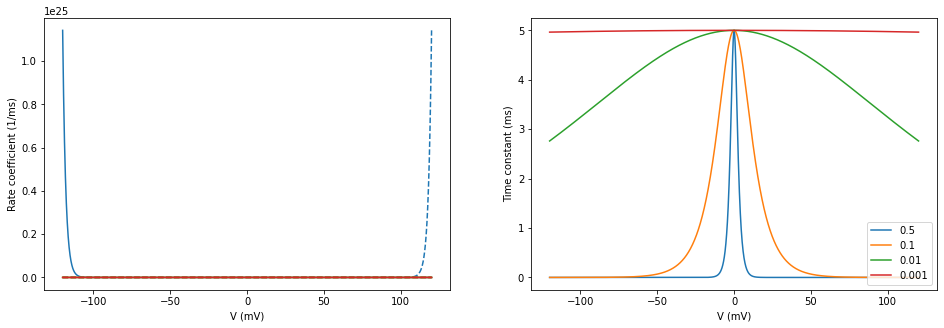

In [12]:
v = np.linspace(-120, 120, 2400)
k1 = lambda b: 1e-1 * np.exp(+b * v)
k2 = lambda b: 1e-1 * np.exp(-b * v)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.xlabel('V (mV)')
plt.ylabel('Rate coefficient (1/ms)')
plt.plot(v, k1(0.5), '--', color='tab:blue', label='0.5')
plt.plot(v, k2(0.5), '-', color='tab:blue')
plt.plot(v, k1(0.1), '--', color='tab:orange', label='0.1')
plt.plot(v, k2(0.1), '-', color='tab:orange')
plt.plot(v, k1(0.01), '--', color='tab:green', label='0.01')
plt.plot(v, k2(0.01), '-', color='tab:green')
plt.plot(v, k1(0.001), '--', color='tab:red', label='0.001')
plt.plot(v, k2(0.001), '-', color='tab:red')

plt.subplot(1, 2, 2)
plt.xlabel('V (mV)')
plt.ylabel('Time constant (ms)')
plt.plot(v, 1 / (k1(0.5) + k2(0.5)), label='0.5')
plt.plot(v, 1 / (k1(0.1) + k2(0.1)), label='0.1')
plt.plot(v, 1 / (k1(0.01) + k2(0.01)), label='0.01')
plt.plot(v, 1 / (k1(0.001) + k2(0.001)), label='0.001')

plt.legend(loc='lower right')
plt.show()

In [Beattie et al. 2017](https://doi.org/10.1113/JP275733), the boundaries $p_{2,4,6,8} \in [10^{-7}, 0.4]\text{mV}^{-1}$ were used.

### Limits on the maximum conductance ($p_9$)

Of the 9 parameters, `p9` is easiest to interpret: It represents the maximum conductance, i.e. the total conductance if all of the channels would be open.
So we can immediately say it must be a positive number.

Unlike $p_1--p_8$, where the existence of cell-to-cell variability is still an open question, we also know for a fact that $g_\text{max}$ varies from cell to cell, and correlates with the expression levels of the corresponding channel genes ([Schulz et al., 2006](https://doi.org/10.1038/nn1639)).
So it will be necessary to estimate boundaries on $p_9$ separately for every cell.

We'll start by estimate a _lower bound_ for it.
Suppose we have the recording below (this is "Cell 1" from [Beattie et al. 2017](https://doi.org/10.1113/JP275733)):

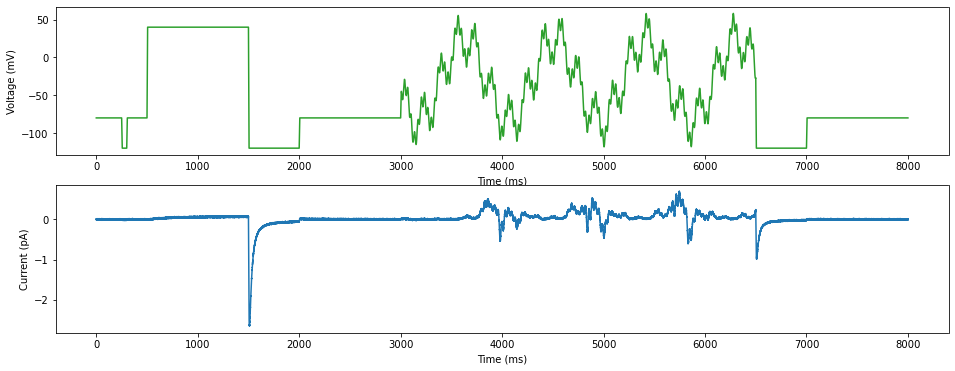

In [13]:
import myokit
import matplotlib.pyplot as plt

log = myokit.DataLog.load('resources/sine-wave-data/cell-1-filtered.zip').npview()

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log.time(), log['voltage'], color='tab:green')
plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(log.time(), log['current'])
plt.show()

This protocol has a peak current of approximately $-2.5\text{pA}$ at around $t_\text{peak} \approx 1500\text{ms}$, when $V = -120\text{mV}$.
From the temperature and concentrations used in recording, we can estimate $E \approx -88.4$ (see section B1.2 of the supplement for [Beattie et al.](https://doi.org/10.1113/JP275733)).

Using $I = g_\text{max} \cdot a \cdot r \cdot (V - E)$ that gives us an estimate for $ g_\text{max} \cdot a(t_\text{peak}) \cdot r(t_\text{peak})$ of approximately:

In [14]:
-2.5 / (-120 + 88.4)

0.07911392405063293

Since $a$ and $r$ both have an upper limit of 1, that gives us a lower limit for $g_\text{max}$ in this cell of $g_\text{max} \geq 0.079 \mu\text{S}$.

The supplement to the [Beattie paper](https://doi.org/10.1113/JP275733) (section B2.3) suggests a slightly more complicated way to estimate a lower bound, by fitting a single exponential to the decaying (deactivating) of the current after the peak, and using its peak as an estimate of the maximum current.

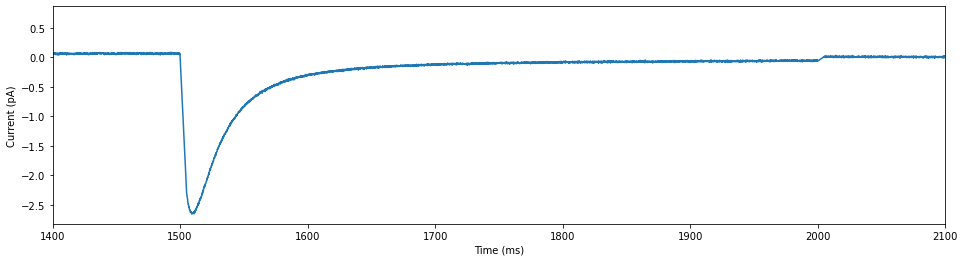

In [15]:
import numpy as np

# Select just the time and current part of the log
times = log.time()
currents = log['current']

# Zoom in on the peak near t=1500s
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.xlim(1400, 2100)
plt.show()

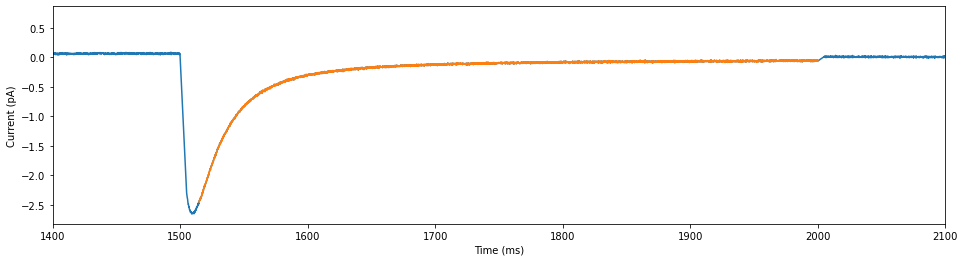

In [16]:
# Find the approximate indices where the current is decaying
i1 = np.where(log['time'] >= 1515)[0][0]
i2 = np.where(log['time'] >= 2000)[0][0]

# Show the decaying part of the current
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.plot(times[i1:i2], currents[i1:i2])
plt.xlim(1400, 2100)
plt.show()

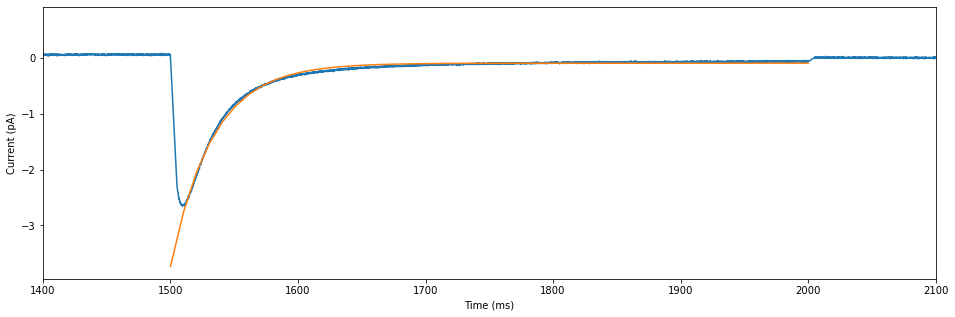

-3.738152019591143


In [17]:
# Select the decaying part, and time-shift it so that t=1500ms becomes t=0ms
tfit = times[i1:i2] - 1500
ifit = currents[i1:i2]

# Fit a single exponential using scipy
import scipy.optimize
f = lambda t, a, b, c: a + b * np.exp(c * t)
xopt, _ = scipy.optimize.curve_fit(f, tfit, ifit, p0=[-0.1, -1, -0.1])
a, b, c = xopt

# Show the fit
tfit = np.linspace(1500, 2000)
ifit = f(tfit - 1500, a, b, c)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.plot(tfit, ifit)
plt.xlim(1400, 2100)
plt.show()

# Show value of the extrapolation at t=1500ms
print(a + b)

In [18]:
print(a + b)

-3.738152019591143


This is an estimate for what the current at the start of the step would have been, if recovery had been instantaneous.
We repeat our earlier calculation to find:

In [19]:
(a + b) / (-120 + 88.4)

0.1182959499870615

So our new lower limit becomes $g_\text{max} \geq 0.118 \mu\text{S}$.

What about the _upper bound?_

Using the exponential fit above, we could make the assumption that the peak of the exponential curve corresponds to the situation where $a$ is still at its value from the previous step to $40\text{mV}$ while $r$ has instantaneously jumped to its steady state value for $-120\text{mV}$.
If we make the further assumptions that $a$ was almost at its steady state $a \approx a_\infty(40\text{mv})$ and that $a_\infty(40) \approx 1 \approx r_\infty(-120)$, then we might use this number as a direct estimate for $g_\text{max}$.
And in fact, the $40\text{mV}$ and $-120\text{mV}$ steps at the start of this protocol were placed there precisely to elicit as large a current as possible.

To create an upper bound, we can then estimate how far off from the true maximum we might be.
For example, if we estimate that $a_\infty(40)$ and $r_\infty(-120)$ are both $> 0.9$, we get an estimate of the upper bound as $1 / 0.9^2 \approx 1.23$ times the lower bound.
If we're not _quite_ as confident in all the approximations above, we might use $1 / 0.5^2 = 4$ times the lower bound.
In the Beattie 2017 paper, an upper bound of ten times the lower bound was used.

## Using boundaries in an optimisation

We can now set up an example using the lower and upper boundaries defined above.

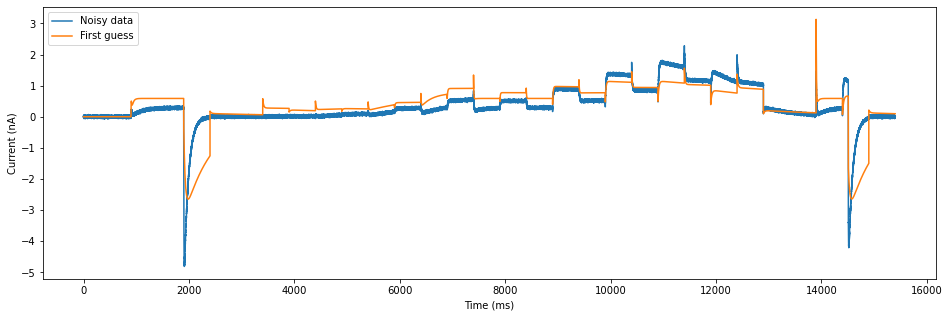

In [20]:
# Load a protocol and create a foward model instance
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Generate the sampling points
t_max = 15400
times = np.arange(0, t_max, 0.1)

# Generate some noisy data
values = model.simulate(parameters, times) + np.random.normal(0, 0.02, times.shape)

# Define a problem and an error measure
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Define boundaries
a1, a2 = 1e-7, 1e3
b1, b2 = 1e-7, 0.4
g1, g2 = 0.1, 1
lower = [a1, b1, a1, b1, a1, b1, a1, b1, g1]
upper = [a2, b2, a2, b2, a2, b2, a2, b2, g2]
boundaries = pints.RectangularBoundaries(lower, upper)

# Choose a slightly random starting point
x0 = parameters * 2**np.random.normal(0, 0.5, len(parameters))

# Show the intial guess
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='First guess')
plt.legend(loc='upper left')
plt.show()

In [21]:
# Create an optimisation controller with boundaries
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.CMAES)

# Enable parallelisation (multi-processing)
opt.set_parallel(True)

# Run the optimisation
xbest, fbest = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     0.486      0:00.1
1     20     0.415      0:00.1
2     30     0.339      0:00.1
3     40     0.339      0:00.2
20    210    0.167      0:00.7
40    410    0.126      0:01.2
60    610    0.126      0:01.8
80    810    0.0805     0:02.4
100   1010   0.0698     0:02.9
120   1210   0.0672     0:03.4
140   1410   0.0641     0:04.0
160   1610   0.0619     0:04.5
180   1810   0.0588     0:05.1
200   2010   0.058      0:05.7
220   2210   0.057      0:06.2
240   2410   0.0534     0:06.8
260   2610   0.05       0:07.4
280   2810   0.047      0:08.0
300   3010   0.0465     0:08.5
320   3210   0.046176   0:09.1
340   3410   0.0461     0:09.6
360   3610   0.046      0:10.2
380   3810   0.0459     0:10.7
400   4010   0.0458     0:11.2
420   4210   0.0457     0:11.8
440   4410   0.0456     0:12.4
460   461

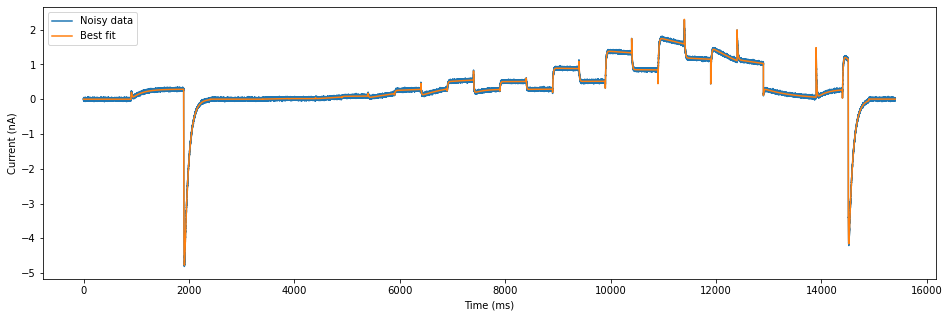

In [22]:
# Show the final result
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(xbest), label='Best fit')
plt.legend(loc='upper left')
plt.show()

## Setting boundaries on rates

A final strategy employed in [Beattie et al. 2017](https://doi.org/10.1113/JP275733) is to set boundaries on the _maximum rate coefficients during a simulation_.
This makes physiological sense, but also stops the rates from becoming so high that the ODE solver gets into (numerical) trouble.

In the Beattie et al. paper, the chosen bounds were

\begin{align}
k_\text{min} = 1.67e-5 \text{ms}^{-1} \\
k_\text{max} = 1000 \text{ms}^{-1}
\end{align}

where the value for $k_\text{max}$ was chosen to equal the upper bound for $a$-type parameters, while the lower bound equals $1 / 1 \text{minute} = 1/60000 \text{ms}^{-1}$.

The maximum rates occur when the voltage is highest (for rates with positive voltage dependence) or lowest (for rates with positive negative voltage dependence).
In the "simplified staircase" protocol used in this example, the extremes are $-120\text{mV}$ and $+40\text{mV}$, while in the sine wave protocol of the Beattie et al. paper the maximum voltage was $58.25mV$.
If we choose the boundaries wide enough, it shouldn't matter too much which we choose, so in this example we'll stay close to the Beattie et al. values and use $V_\text{low}=-120\text{mV}$ and $V_\text{high}=60\text{mV}$.

$$ I = g_\text{max} \cdot a \cdot r \cdot (V - E) $$

\begin{align}
\dot{a} = (1 - a)k_1 - a k_2
    &&& k_1 = p_1 \exp(p_2 V) \\
    &&& k_2 = p_3 \exp(-p_4 V) \\
\dot{r} = (1 - r)k_4 - r k_3
    &&& k_3 = p_5 \exp(p_6 V) \\
    &&& k_4 = p_7 \exp(-p_8 V)
\end{align}

this leads to the following boundaries:

\begin{align}
k_1 = p_1 \exp(p_2 V_\text{high}) \in [k_\text{min}, k_\text{max}] \\
k_3 = p_5 \exp(p_6 V_\text{high}) \in [k_\text{min}, k_\text{max}] \\
k_2 = p_3 \exp(-p_4 V_\text{low}) \in [k_\text{min}, k_\text{max}] \\
k_4 = p_7 \exp(-p_8 V_\text{low}) \in [k_\text{min}, k_\text{max}]
\end{align}

From this, we can calculate boundaries on the pairs $(p_1, p_2)$, $(p_3, p_4)$, $(p_5, p_6)$, $(p_7, p_8)$.
We can visualise the boundaries by drawing the lines:

\begin{align}
\log(p_1) + p_2 V_\text{high} = \log(k_\text{min}) \\
\log(p_1) + p_2 V_\text{high} = \log(k_\text{max}) \\
\log(p_3) - p_4 V_\text{low} = \log(k_\text{min}) \\
\log(p_3) - p_4 V_\text{low} = \log(k_\text{max})
\end{align}

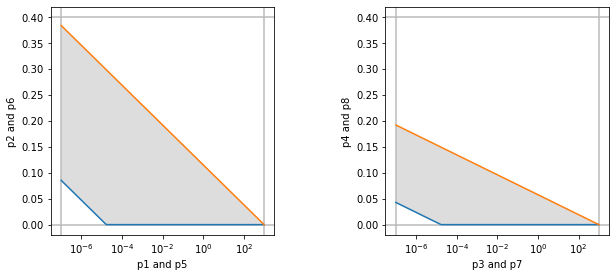

In [23]:
# Define the boundaries on the parameters and maximum rate coefficients
a_min, a_max = 1e-7, 1e3
b_min, b_max = 1e-7, 0.4
km_min, km_max = 1.67e-5, 1e3

def boundary_plot():

    # Define a range on which to plot the rate coefficient boundaries
    # We use a range that's linear in the log-transformed space
    px = np.exp(np.linspace(np.log(a_min), np.log(a_max), 200))

    # Calculate the lower and upper boundaries on p2 and p4 (which are the same as those on p6 and p8)
    p2_min = (np.log(km_min) - np.log(px)) / 60
    p2_max = (np.log(km_max) - np.log(px)) / 60
    p4_min = (np.log(km_min) - np.log(px)) / 120
    p4_max = (np.log(km_max) - np.log(px)) / 120

    # But p2 and p4 are also bounded by the parameter boundaries, so add that in too:
    p2_min = np.maximum(p2_min, b_min)
    p4_min = np.maximum(p4_min, b_min)

    # Create a figure
    fig = plt.figure(figsize=(10, 4.2))
    fig.subplots_adjust(wspace=0.5)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel('p1 and p5')
    ax1.set_ylabel('p2 and p6')
    ax1.set_xscale('log')
    ax1.set_xlim(3e-8, 3e3)
    ax1.set_ylim(-0.02, 0.42)
    ax1.axvline(a_min, color='#bbbbbb')
    ax1.axvline(a_max, color='#bbbbbb')
    ax1.axhline(b_min, color='#bbbbbb')
    ax1.axhline(b_max, color='#bbbbbb')
    ax1.plot(px, p2_min)
    ax1.plot(px, p2_max)
    ax1.fill_between(px, p2_min, p2_max, color='#dddddd')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel('p3 and p7')
    ax2.set_ylabel('p4 and p8')
    ax2.set_xscale('log')
    ax2.set_xlim(3e-8, 3e3)
    ax2.set_ylim(-0.02, 0.42)
    ax2.axvline(a_min, color='#bbbbbb')
    ax2.axvline(a_max, color='#bbbbbb')
    ax2.axhline(b_min, color='#bbbbbb')
    ax2.axhline(b_max, color='#bbbbbb')
    ax2.plot(px, p4_min)
    ax2.plot(px, p4_max)
    ax2.fill_between(px, p4_min, p4_max, color='#dddddd')
    
    return ax1, ax2

boundary_plot()
plt.show()

To implement these boundaries, we need to go beyond standard PINTS boundaries, and define our own!
We can find out how to do this by looking at the [documentation](https://pints.readthedocs.io/en/stable/boundaries.html) for the `Boundaries` class.

In [24]:
class AdvancedBoundaries(pints.Boundaries):
    """
    A boundaries object that implements the maximum-rate boundaries used in Beattie et al.
    
    Parameters
    ----------
    g_min
        A cell-specific lower boundary on the conductance.    
    """
    
    def __init__(self, g_min):
        self.a_min = 1e-7
        self.a_max = 1e3
        self.b_min = 1e-7
        self.b_max = 0.4
        self.km_min = 1.67e-5
        self.km_max = 1e3
        self.g_min = g_min
        self.g_max = 10 * g_min
        self.v_low = -120
        self.v_high = 60
        
        # Univariate paramater bounds
        self.lower = np.array([
            self.a_min, self.b_min,
            self.a_min, self.b_min,
            self.a_min, self.b_min,
            self.a_min, self.b_min,
            self.g_min,
        ])          
        self.upper = np.array([
            self.a_max, self.b_max,
            self.a_max, self.b_max,
            self.a_max, self.b_max,
            self.a_max, self.b_max,
            self.g_max,
        ])
        
    def n_parameters(self):
        return 9
    
    def check(self, parameters):
        
        # Check parameter boundaries
        if np.any(parameters <= self.lower) or np.any(parameters >= self.upper):
            return False
        
        # Check rate boundaries
        k1m = parameters[0] * np.exp(parameters[1] * self.v_high)
        if k1m <= self.km_min or k1m >= self.km_max:
            return False
        k2m = parameters[2] * np.exp(-parameters[3] * self.v_low)
        if k2m <= self.km_min or k2m >= self.km_max:
            return False
        k3m = parameters[4] * np.exp(parameters[5] * self.v_high)
        if k3m <= self.km_min or k3m >= self.km_max:
            return False
        k4m = parameters[6] * np.exp(-parameters[7] * self.v_low)
        if k4m <= self.km_min or k4m >= self.km_max:
            return False
        
        # All tests passed!
        return True

boundaries = AdvancedBoundaries(g_min=0.1)

We can test our advanced boundaries by running it on a few points and plotting the results on the diagram we made earlier:

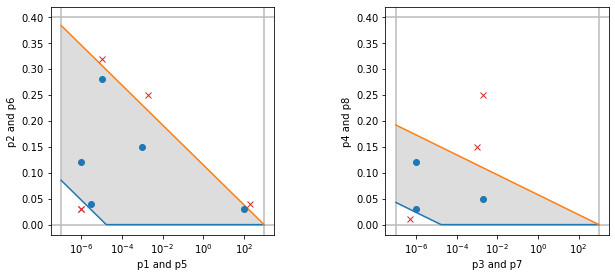

In [25]:
# Create a plot of the boundaries
ax1, ax2 = boundary_plot()

# Select a point within the boundaries
p_good = np.array([1e-2, 0.15, 1e-2, 0.05, 1e-2, 0.15, 1e-2, 0.05, 0.5])

# Create a method that draws a point in p1/p2 space
def check_p1p2(p1, p2):
    p = np.copy(p_good)
    p[0] = p1
    p[1] = p2
    if boundaries.check(p):
        ax1.plot(p1, p2, 'o', color='tab:blue')
    else:
        ax1.plot(p1, p2, 'x', color='tab:red')

# Create a method that draws a point in p3/p4 space
def check_p3p4(p3, p4):
    p = np.copy(p_good)
    p[2] = p3
    p[3] = p4
    if boundaries.check(p):
        ax2.plot(p3, p4, 'o', color='tab:blue')
    else:
        ax2.plot(p3, p4, 'x', color='tab:red')

check_p1p2(1e-3, 0.15)
check_p1p2(2e-3, 0.25)
check_p1p2(1e-6, 0.12)
check_p1p2(1e-6, 0.03)
check_p1p2(1e-5, 0.32)
check_p1p2(1e-5, 0.28)
check_p1p2(1e-6, 0.03)
check_p1p2(3e-6, 0.04)
check_p1p2(1e2, 0.03)
check_p1p2(2e2, 0.04)

check_p3p4(1e-3, 0.15)
check_p3p4(2e-3, 0.25)
check_p3p4(2e-3, 0.05)
check_p3p4(1e-6, 0.12)
check_p3p4(1e-6, 0.03)
check_p3p4(5e-7, 0.01)
plt.show()

Finally, we run an optimisation as before, but now using our new boundaries:

In [26]:
# Create an optimisation controller with boundaries
boundaries = AdvancedBoundaries(0.1)
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.CMAES)

# Enable parallelisation (multi-processing)
opt.set_parallel(True)

# Run the optimisation
xbest, fbest = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     0.152      0:00.1
1     20     0.125      0:00.1
2     30     0.122      0:00.1
3     40     0.122      0:00.2
20    210    0.119      0:00.6
40    408    0.111      0:01.2
60    606    0.0956     0:01.7
80    786    0.036      0:02.2
100   971    0.0136     0:02.7
120   1171   0.0105     0:03.2
140   1371   0.0063     0:03.8
160   1571   0.00504    0:04.4
180   1771   0.0023     0:04.9
200   1971   0.00177    0:05.4
220   2171   0.00165    0:05.9
240   2371   0.00102    0:06.5
260   2571   0.00058    0:07.1
280   2771   0.000558   0:07.7
300   2971   0.000531   0:08.3
320   3171   0.000456   0:08.9
340   3371   0.000442   0:09.4
360   3571   0.000441   0:09.9
380   3771   0.000438   0:10.4
400   3971   0.000424   0:11.0
420   4171   0.000403   0:11.5
440   4371   0.0004     0:12.0
460   457

## Can we check if the boundaries are "right"?

Can we check if the boundaries we estimated are alright?
One way of doing this would be to fit using the boundaries, and see if we find a good fit somewhere far from the edges of the boundaries we set.
(Although this does assume that we haven't found some local minimum, and that a better global minimum doesn't exist somewhere beyond our boundaries!)

An indication that the boundaries could be _wrong_ can be seen if an optimiser frequently returns points right on the edges of the boundaries.

## Summary

In this notebook, we have

- Seen how we can make our search robust against "bad" parameter values, but also decided evaluating such parameters is a waste of time.
- Used prior knowledge of the current we're investigating to defined boundaries on parameter values and calculated values (the rate coefficients).
- Implemented boundary checking in PINTS.

Some of the classes we've created here will be useful in further notebooks, so we've stored them in the file [library.py](library.py).

In the next notebook we'll use the boundaries defined here to sample initial starting points for our optimisation.